In [2]:
import train as train
import generate
import eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
BASE_DIR = "./experiments/sanity_check_mcmc"
PROFILE = "sin-1x-mcmc"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-1x-10k ======


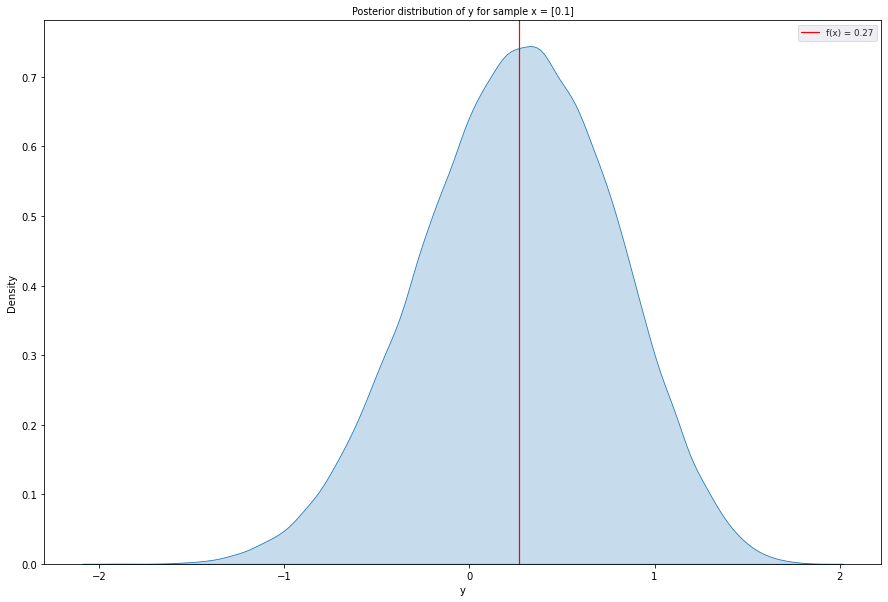

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
_, _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_train=False, load_val=False)

In [7]:
x_test[0], y_test[0]

(tensor([-0.5392]), tensor(-1.0654))

<AxesSubplot:>

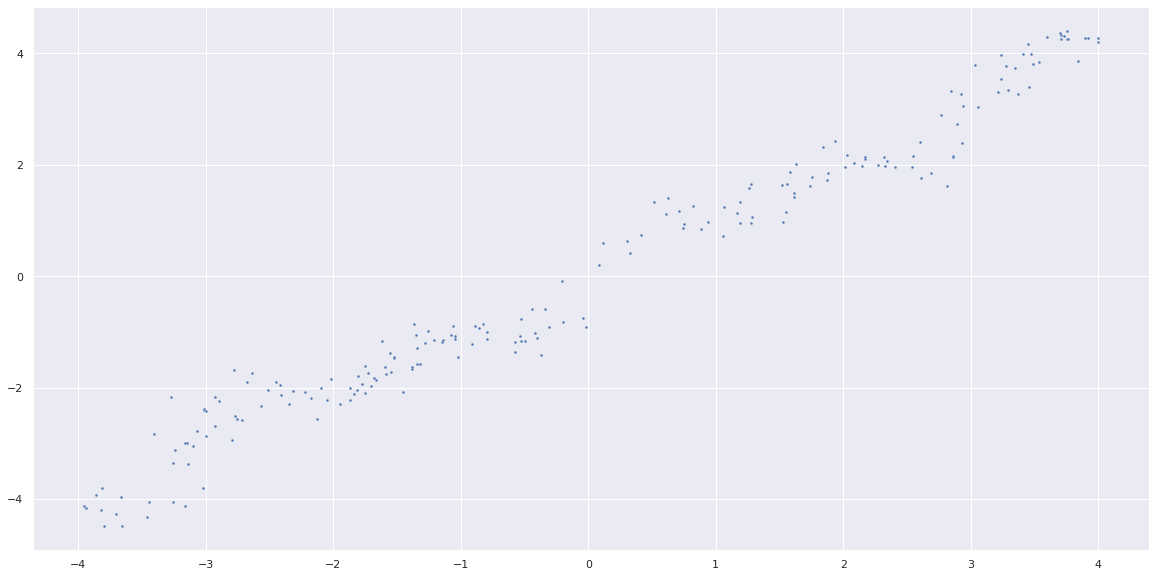

In [8]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.scatterplot(x=x_test.flatten(), y=y_test, s=8)

In [8]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    infer_model = train.train(config, f"{BASE_DIR}")

Using device: cpu
===== Training profile sin-1x =====


Sample: 100%|██████████| 150/150 [06:21,  2.54s/it, step size=6.68e-04, acc. prob=0.951]


[0:06:22][mcmc finished] rmse: 0.33
Saved model and samples to ./experiments/sanity_check_mcmc/models/sin-1x


In [9]:
inference_model = eval.load_model(BASE_DIR, config)

Loaded model and samples from ./experiments/sanity_check_mcmc/models/sin-1x


In [22]:
inference_model.mcmc.diagnostics()

{'fc.0.0.linear.bias': OrderedDict([('n_eff',
               tensor([ 3.8121,  4.1454,  5.5996,  4.5152,  2.9133,  4.2356,  2.4310, 13.3183,
                       10.3022,  5.0932,  9.6235,  9.8053,  3.4183,  3.1735,  5.8935,  3.8118,
                        7.6919,  6.2319,  5.2252,  2.8759,  6.6032,  9.6475,  6.8266,  3.2727,
                        3.4561,  4.1005,  2.7423,  5.0761,  5.4113,  2.4170,  2.8926,  5.6843])),
              ('r_hat',
               tensor([1.2823, 1.4136, 1.2552, 1.3423, 2.0611, 1.0919, 3.2685, 1.0372, 1.1487,
                       1.5094, 1.0182, 0.9955, 1.7094, 1.9076, 1.0209, 1.6378, 1.0861, 1.0401,
                       0.9901, 1.9625, 1.1950, 1.0186, 1.2446, 2.2590, 1.6949, 1.2806, 2.1469,
                       1.1533, 1.2343, 3.3721, 2.1745, 1.1323]))]),
 'fc.0.0.linear.weight': OrderedDict([('n_eff',
               tensor([[ 4.8307],
                       [ 9.7592],
                       [ 2.9074],
                       [ 6.6883],
          

In [10]:
predictive = inference_model.get_predictive(num_predictions=500)
samples = predictive(x_test)
samples.keys()

dict_keys(['obs', '_RETURN'])

In [11]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

pred_summary = summary(samples)

In [12]:
y = pred_summary["obs"]
mu = pred_summary["_RETURN"]
predictions = pd.DataFrame({
    "x": x_test.flatten(),
    "mu": mu["mean"].flatten(),
    "mu_5": mu["5%"].flatten(),
    "mu_95": mu["95%"].flatten(),
    "y_mean": y["mean"].flatten(),
    "y_5": y["5%"].flatten(),
    "y_95": y["95%"].flatten(),
    "true_y": y_test.flatten()
})

In [13]:
predictions.head()

,x,mu,mu_5,mu_95,y_mean,y_5,y_95,true_y
0,-0.539227,-0.997797,-1.045222,-0.947693,-0.989397,-1.547124,-0.411093,-1.065415
1,1.278432,1.576162,0.886856,2.757483,1.584536,0.631383,3.087984,1.649818
2,-3.244102,-5.877765,-22.991137,9.555603,-5.844172,-23.073469,9.777733,-3.113240
3,-1.549847,-1.320472,-4.392441,1.305919,-1.314757,-4.283883,1.342909,-1.719863
4,2.688141,7.916793,-7.526895,23.778410,7.919370,-7.901220,23.783743,1.855075


In [14]:
sorted_pred = predictions.sort_values(by='x')

def plot_predictions(summary):
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['mu'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['mu_5'], y2=summary['mu_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)
    
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['y_mean'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['y_5'], y2=summary['y_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)

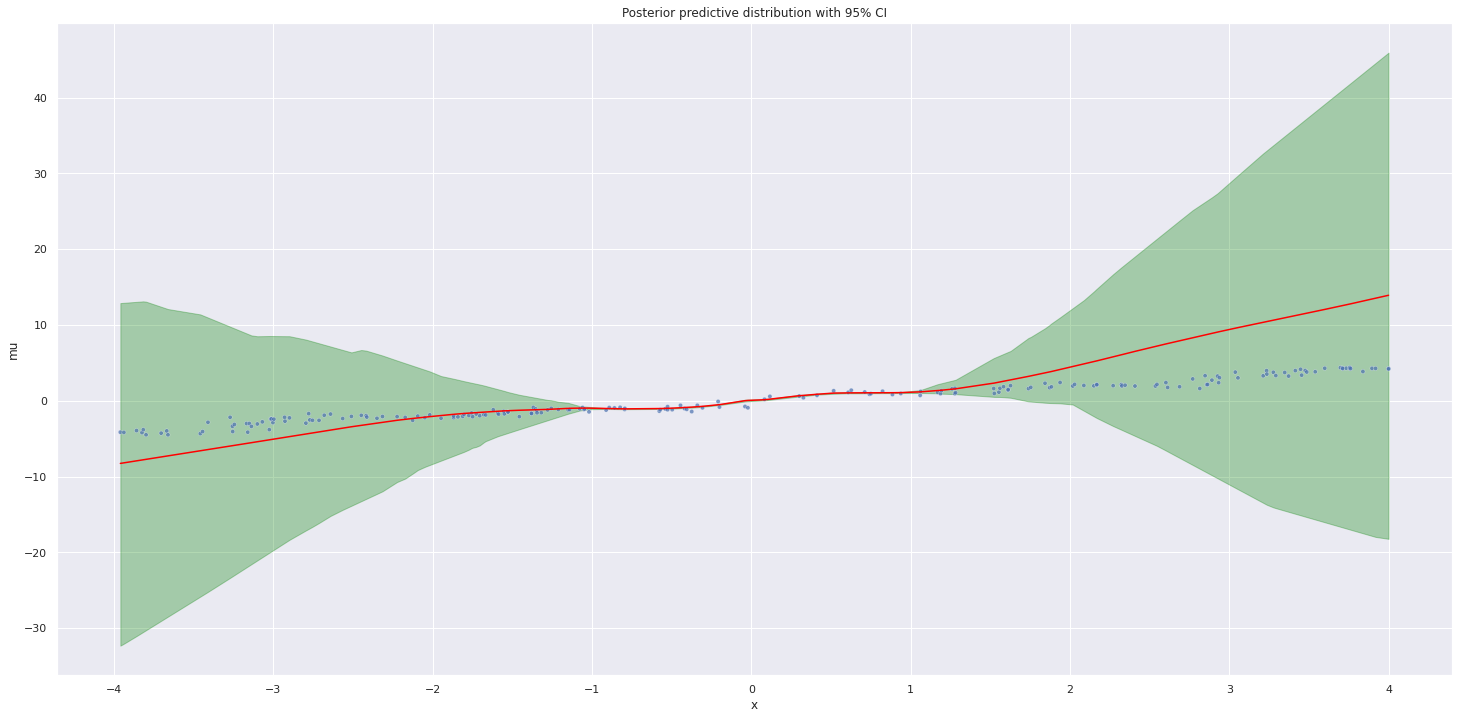

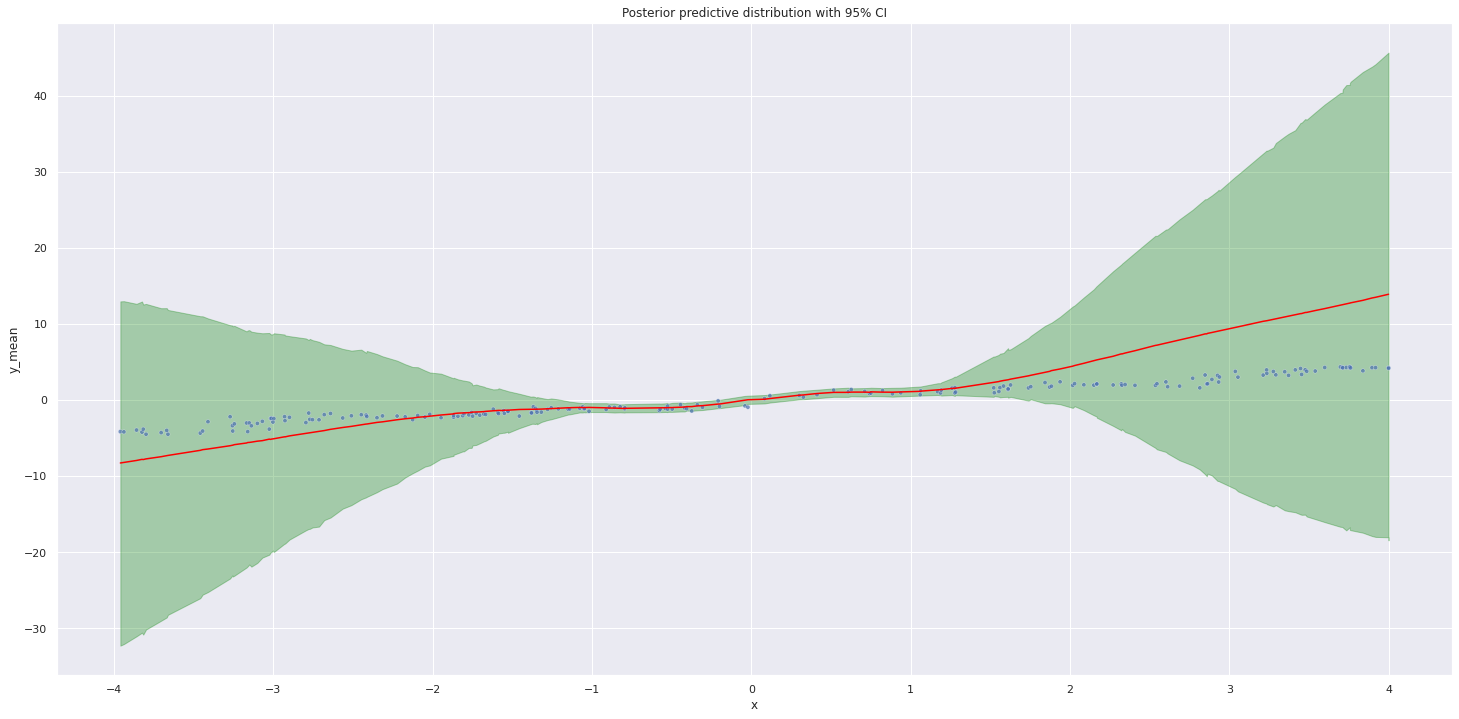

In [15]:
plot_predictions(sorted_pred)

Loaded model and samples from ./experiments/sanity_check_mcmc/models/sin-1x
using device: cpu
====== evaluating profile sin-1x ======
Eval done in 0:01:15.043103


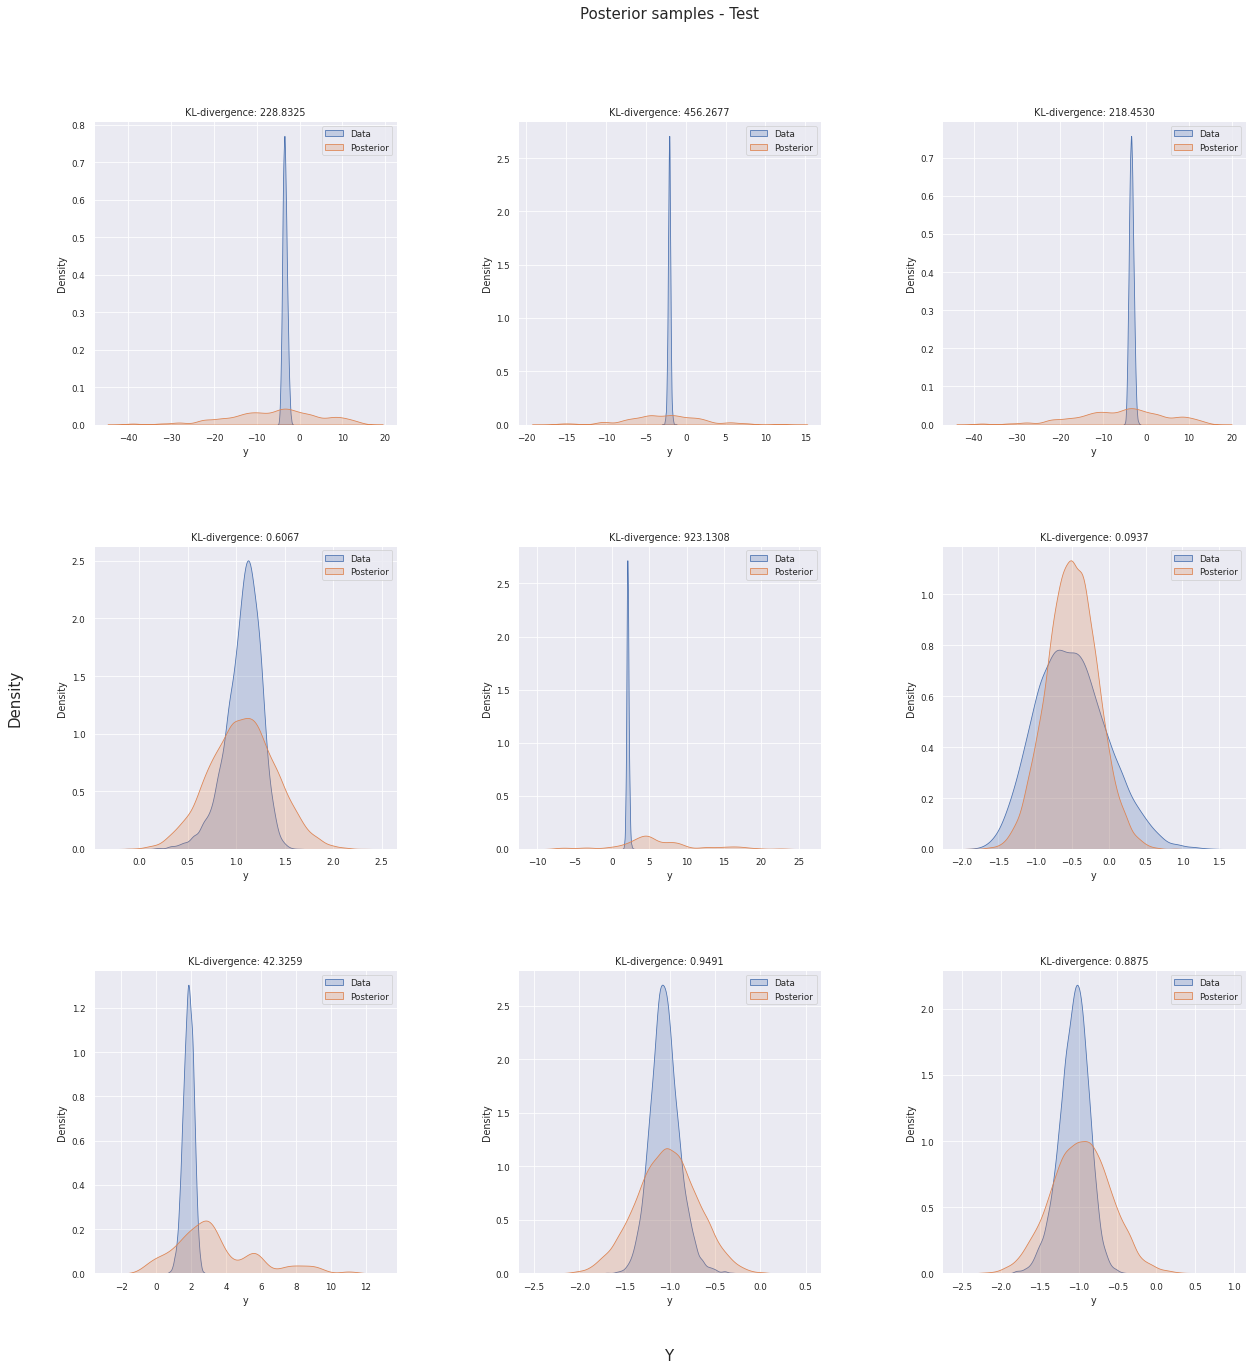

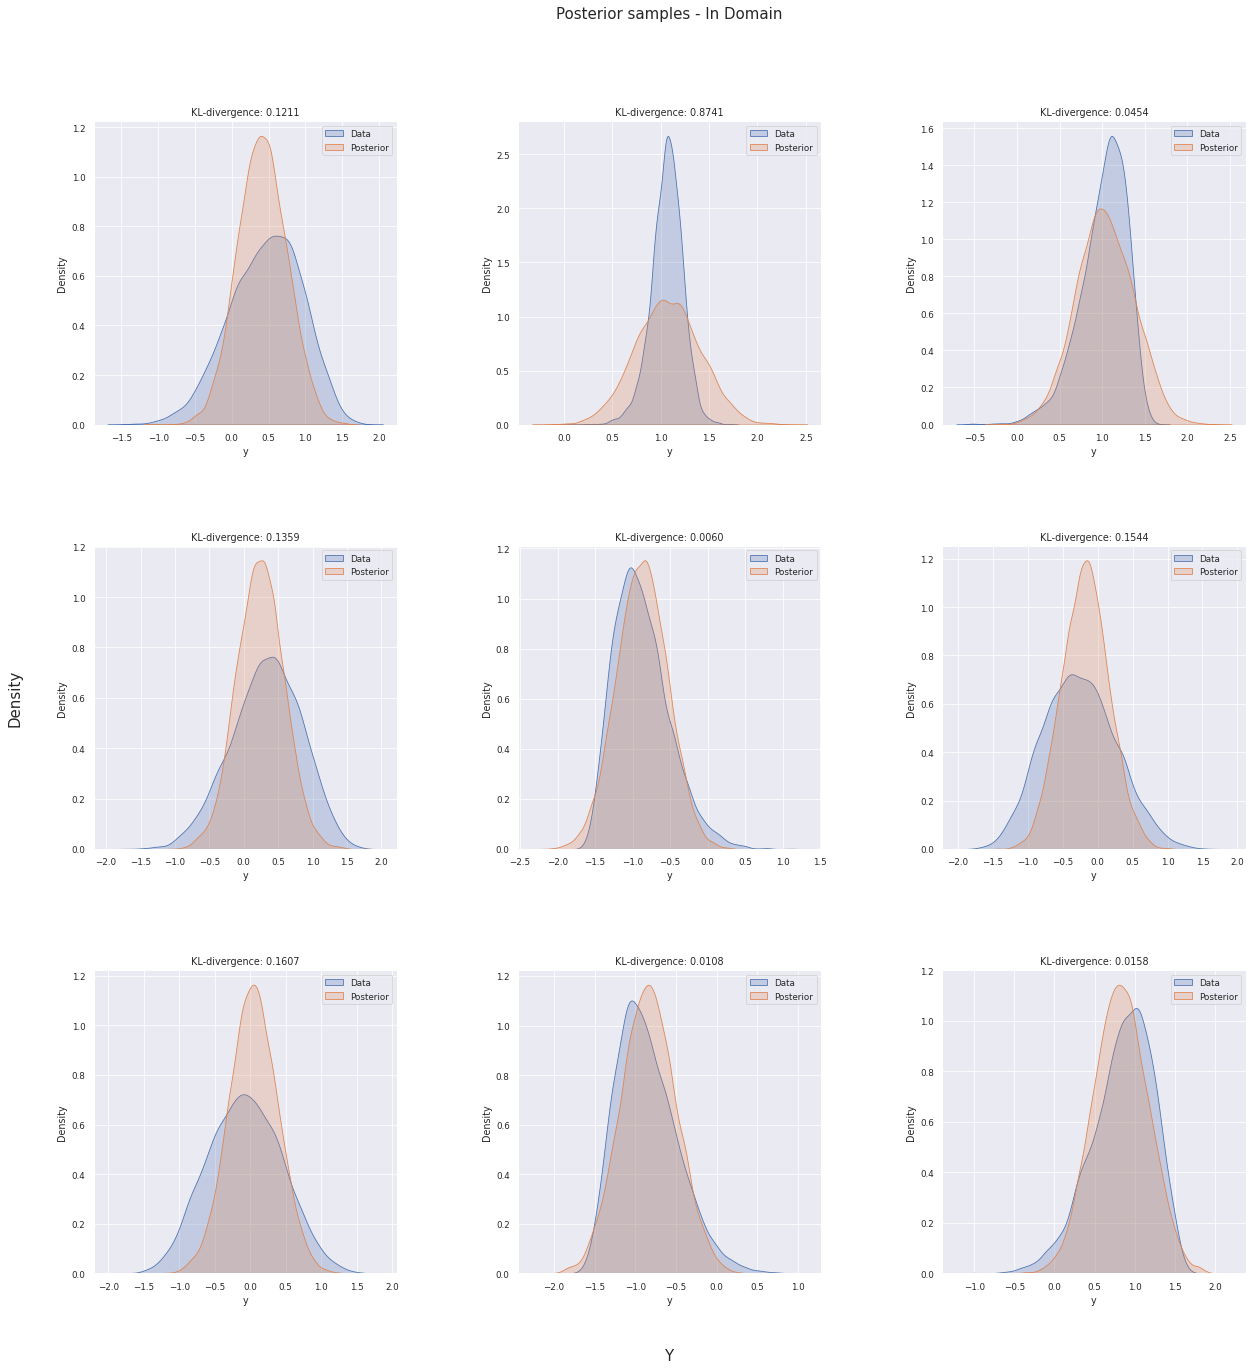

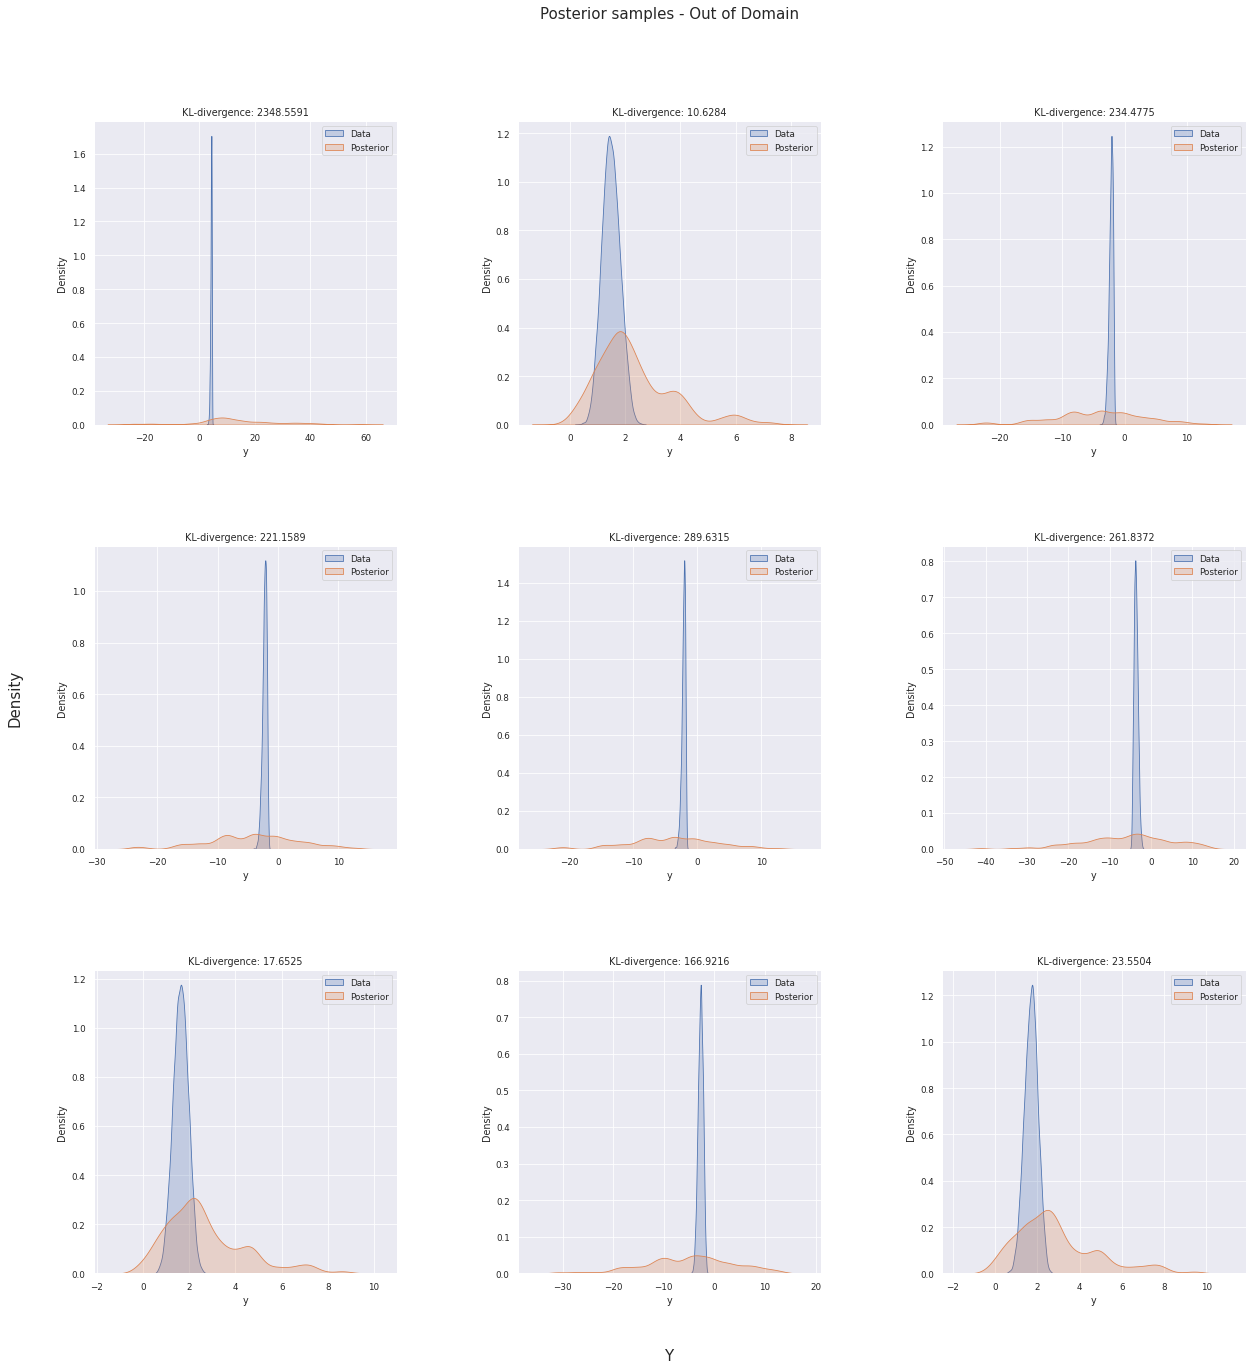

In [16]:
if True:
            if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")

            eval.eval(config, dataset_config, f"{BASE_DIR}")